# Object Detection - 尋找威利

Copyright © 2019 Hsu Shih-Chieh  

Dataset: https://github.com/vc1492a/Hey-Waldo


In [1]:
%load_ext autoreload
%autoreload 2
import os, warnings, sys, cv2
warnings.filterwarnings("ignore")
sys.path.append('..')
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from utils import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss, get_random_data
from timeit import default_timer as timer
#from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
from datasets import load_motoranchordata
from utils import YOLOV3
from IPython.display import HTML, IFrame
import glob
import xml.etree.ElementTree as ET
from functools import partial
from PIL import Image, ImageFont, ImageDraw
from IPython.display import display
os.environ['CUDA_VISIBLE_DEVICES']='1' 

Using TensorFlow backend.
W1031 08:50:50.335556 140700216837888 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Segmentation Models: using `keras` framework.


In [2]:
%%html
<img src="wally.jpg" height="500" width="500" align='center'>

## 安裝標注軟體

labelImg網址: https://github.com/tzutalin/labelImg
安裝方法: pip install labelImg


In [3]:
!labelImg

/bin/sh: 1: labelImg: not found


## 標註Wally

In [4]:
!cat wally/1.xml

<annotation>
	<folder>wally</folder>
	<filename>1.jpg</filename>
	<path>/Users/jayhsu/work/Intelligent Manufacturing/tutorial/wally/1.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>2048</width>
		<height>1251</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>wally</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>708</xmin>
			<ymin>511</ymin>
			<xmax>751</xmax>
			<ymax>586</ymax>
		</bndbox>
	</object>
</annotation>


## 轉換標注檔
- 把剛剛標注完的xml檔, 整合成一個train.txt  
- 把xml裡面的bbox資訊都會整到train.txt   
<br>
格式：  
path/to/image_001.jpg x1, y1, x2, y2 class, ...

In [22]:

list_file = open('train.txt', 'w')
classes = ['wally']
wd = os.getcwd()    
paths = glob.glob('wally/*.xml')
for xmlpath in paths:
    imagepath = xmlpath.replace('xml','jpg')
    imagepath = os.path.join(wd, imagepath)
    list_file.write(imagepath)    
    #convert_annotation(xmlpath, list_file)
    in_file = open(xmlpath)
    tree=ET.parse(in_file)
    root = tree.getroot()
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))    
    list_file.write('\n')
list_file.close()  




In [23]:
!head -n 5 train.txt

/home/bigdata/MITEAM/Case_Practice/tutorial/wally/5_1_0.jpg 215,204,237,247,0
/home/bigdata/MITEAM/Case_Practice/tutorial/wally/14.jpg 198,1870,250,1976,0
/home/bigdata/MITEAM/Case_Practice/tutorial/wally/9_0_2.jpg 37,200,58,235,0 11,197,35,233,0 4,121,23,159,0 27,125,44,159,0 41,141,66,178,0
/home/bigdata/MITEAM/Case_Practice/tutorial/wally/13_0_2.jpg 170,220,193,256,0
/home/bigdata/MITEAM/Case_Practice/tutorial/wally/11_3_3.jpg 166,1,208,48,0


## Generator
- 批次把照片丟給model訓練
- 在批次產生照片的過程中可以加上image augmentation (get_random_data), 藉此設計出無限多的訓練照片
- 可以參考keras.Sequence, 是一個更標準化的做法

In [24]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size) 

        
path = 'train.txt'
with open(path) as f:
    lines = f.readlines() 
anchors_str= '10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326'
anchors = np.array([float(x) for x in anchors_str.split(',')]).reshape(-1, 2)
data_generator_simple = partial(data_generator,  batch_size=10, input_shape=(416,416), anchors=anchors, num_classes=1)    
val_split = 0.1
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val    

gen_tr = data_generator_simple(lines[:num_train])    
gen_val = data_generator_simple(lines[num_train:])    



## Create YOLOv3 Model
- 這部分的code通常都是有大神發表了paper, 然後有人實作好放在keras上, 然後我們就可以拿下來用
- 不同人的實作會不太一樣, 找到一個好的code base可以事半功倍
- 也可以自己看paper實作

In [25]:
def create_model():
    '''create the training model'''
    num_classes=1
    input_shape = (416,416) 
    anchors_str= '10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326'
    anchors = np.array([float(x) for x in anchors_str.split(',')]).reshape(-1, 2)    
    weights_path='../model/yolov3_weights.h5'
    
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
    print('Load weights {}.'.format(weights_path))
    #if freeze_body in [1, 2]:
    #    num = (185, len(model_body.layers)-3)[freeze_body-1]
    #    for i in range(num): model_body.layers[i].trainable = False
    #    print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

model = create_model() 


Create YOLOv3 model with 9 anchors and 1 classes.
Load weights ../model/yolov3_weights.h5.


## 訓練


In [26]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)


model.compile(optimizer=Adam(lr=1e-3), loss={
    'yolo_loss': lambda y_true, y_pred: y_pred})

batch_size = 7
model.fit_generator(gen_tr, validation_data=gen_val,
        steps_per_epoch=10, validation_steps=3,
        epochs=200, initial_epoch=0, callbacks=[reduce_lr])

    
model.save_weights('wally.h5')


Epoch 1/200
10/10 [==============================] - 14s 1s/step - loss: 3505.3340 - val_loss: 4487927.5833
Epoch 2/200
10/10 [==============================] - 5s 457ms/step - loss: 369.3869 - val_loss: 26854.2865
Epoch 3/200
10/10 [==============================] - 5s 456ms/step - loss: 143.4495 - val_loss: 157.7719
Epoch 4/200
10/10 [==============================] - 5s 458ms/step - loss: 95.7887 - val_loss: 85.6293
Epoch 5/200
10/10 [==============================] - 5s 457ms/step - loss: 75.8572 - val_loss: 102.7885
Epoch 6/200
10/10 [==============================] - 5s 458ms/step - loss: 64.5061 - val_loss: 64.9195
Epoch 7/200
10/10 [==============================] - 5s 481ms/step - loss: 58.2092 - val_loss: 61.8602
Epoch 8/200
10/10 [==============================] - 5s 540ms/step - loss: 53.6341 - val_loss: 56.6082
Epoch 9/200
10/10 [==============================] - 5s 548ms/step - loss: 50.3587 - val_loss: 52.9669
Epoch 10/200
10/10 [==============================] - 5s 539m

In [10]:
model.save_weights('wally.h5')

## 測試


In [39]:

def drawimg(img, box):
    print(box)
    draw = ImageDraw.Draw(img)
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
    #print((left, top), (right, bottom))
    for i in range(3):
        draw.rectangle([left - i, top - i, right + i, bottom + i], outline=(0,255,0), fill = None)
    return img

#yolo=YOLOV3(model_path='wally.h5', iou=0.25)

2
[ 21.392715 229.05663   67.032974 255.03029 ]
[ -5.408415 229.56223   34.982407 254.51709 ]


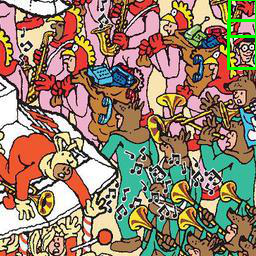

3
[ 9.019688 49.680183 59.747456 79.00669 ]
[ 12.335625 229.21127   55.97338  254.61981 ]
[140.71237 229.43791 183.45236 254.83101]


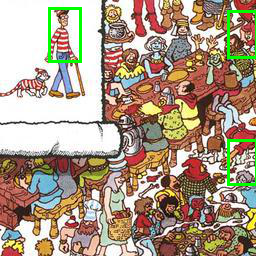

0


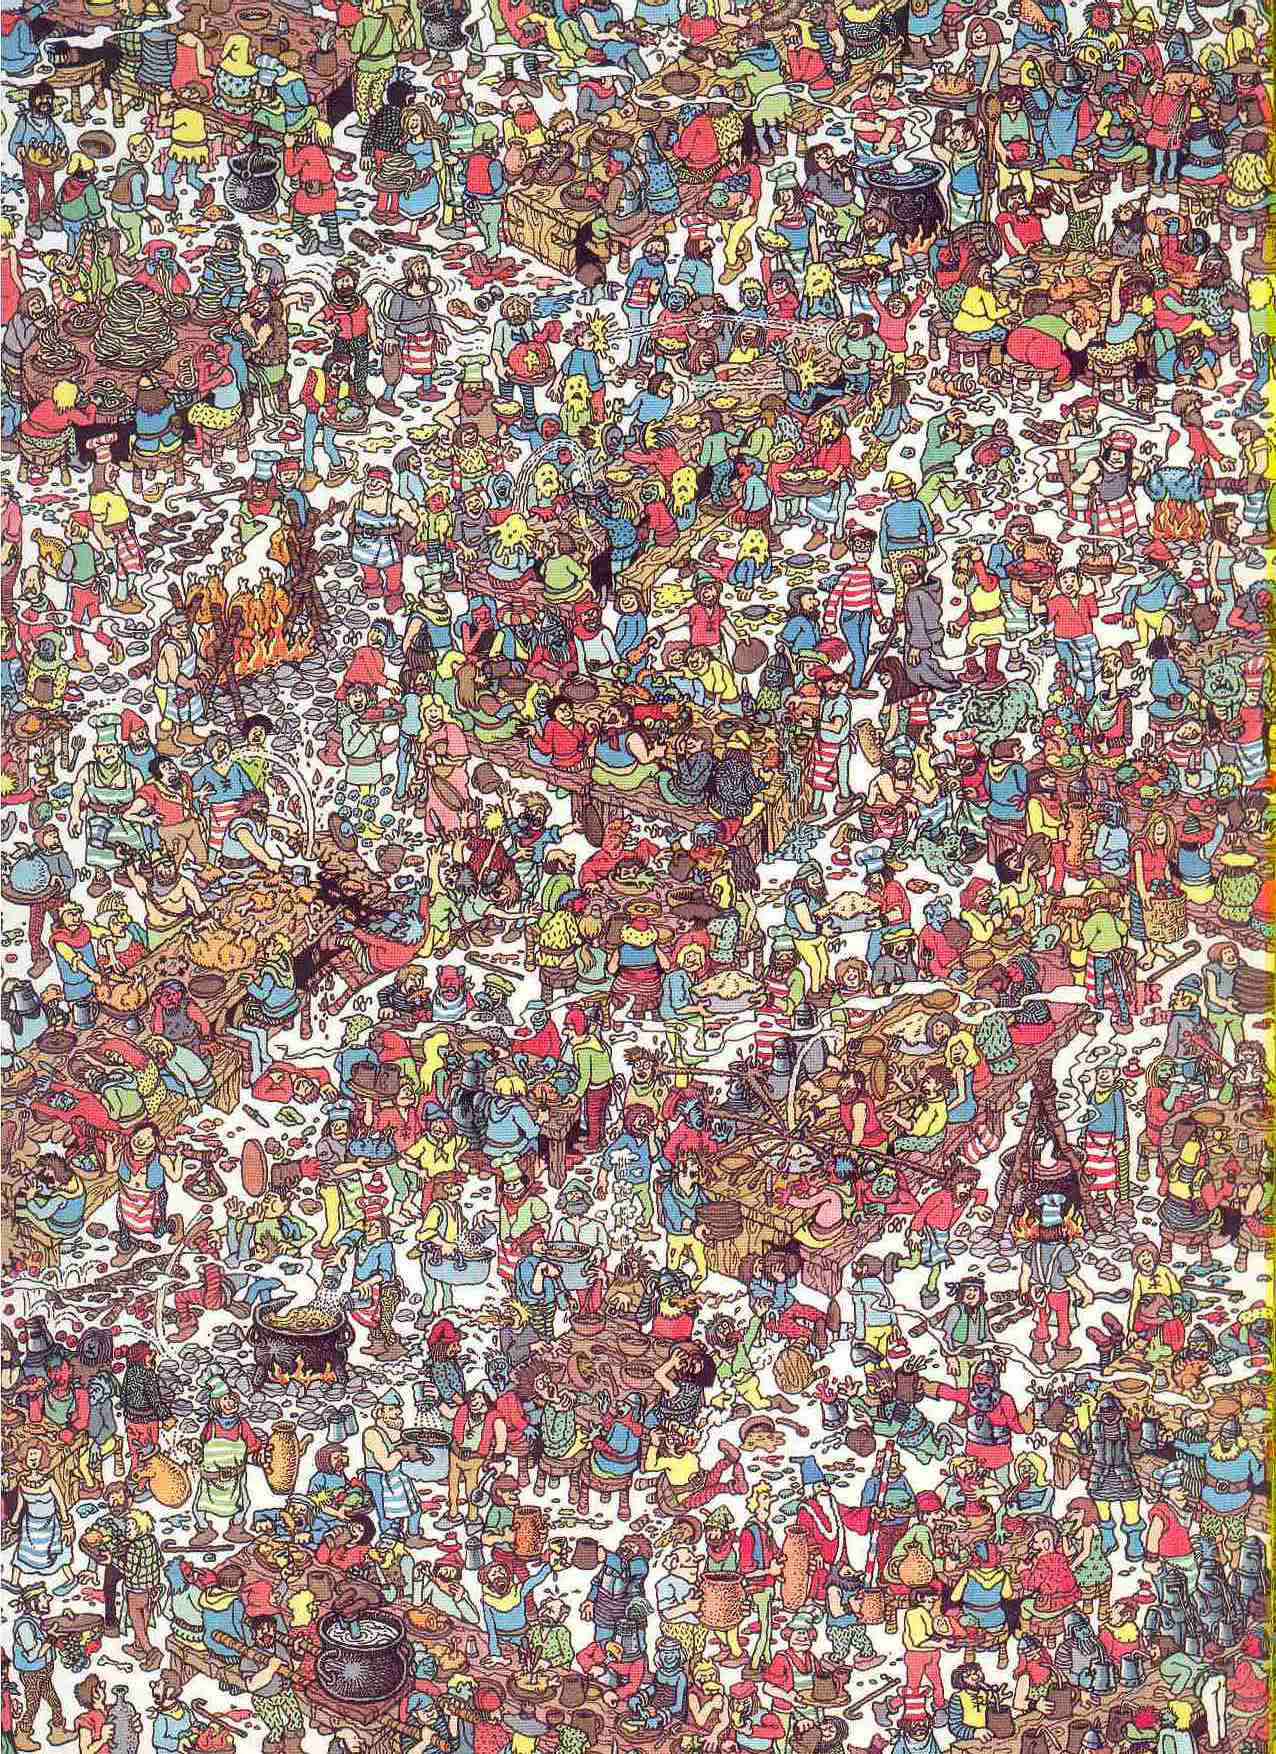

In [47]:


tests = ['wally/10_3_1.jpg', 'wally/9_0_3.jpg', 'wally/12.jpg']
for path in tests:
    image = Image.open(path)
    boxes = yolo.detect_image(image)
    print(len(boxes))
    img = image.copy()
    for box in boxes:
        img = drawimg(img,box)
    display(img)


In [42]:
ls -l wally/

總計 25216
-rw-r--r-- 1 bigdata bigdata   33112 Oct 31 09:14 10_3_1.jpg
-rw-r--r-- 1 bigdata bigdata     517 Oct 31 09:14 10_3_1.xml
-rw-r--r-- 1 bigdata bigdata  896644 Oct 31 09:14 10.jpg
-rw-r--r-- 1 bigdata bigdata     771 Oct 31 09:14 10.xml
-rw-r--r-- 1 bigdata bigdata   24691 Oct 31 09:14 11_1_2.jpg
-rw-r--r-- 1 bigdata bigdata     519 Oct 31 09:14 11_1_2.xml
-rw-r--r-- 1 bigdata bigdata   27382 Oct 31 09:14 1_1_1.jpg
-rw-r--r-- 1 bigdata bigdata     514 Oct 31 09:14 1_1_1.xml
-rw-r--r-- 1 bigdata bigdata   25022 Oct 31 09:14 11_3_3.jpg
-rw-r--r-- 1 bigdata bigdata     516 Oct 31 09:14 11_3_3.xml
-rw-r--r-- 1 bigdata bigdata 2962470 Oct 31 09:14 11.jpg
-rw-r--r-- 1 bigdata bigdata   23802 Oct 31 09:14 12_0_0.jpg
-rw-r--r-- 1 bigdata bigdata     518 Oct 31 09:14 12_0_0.xml
-rw-r--r-- 1 bigdata bigdata   28439 Oct 31 09:14 12_0_3.jpg
-rw-r--r-- 1 bigdata bigdata     516 Oct 31 09:14 12_0_3.xml
-rw-r--r-- 1 bigdata bigdata  422732 Oct 31 09:14 12.jpg
-rw-r--r-- 1 bigdata bigdata     